In [1]:
import torch
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

**Dataset**

In [2]:
import sys
from torch.utils.data import random_split
sys.path.append('../')  # Adjust the path accordingly

from VQA_Dataset_BLIP import VQA_Dataset_preloaded
from transformers import BlipProcessor, BlipImageProcessor

text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

#dataset = VQA_Dataset_preloaded(device)
#dataset.compute_store(text_processor, image_processor, length=4000, fileName="embeddingsBLIPWithMultipleChoiceImageSize384Length11_4k.h5")

In [3]:
datasetLoaded = VQA_Dataset_preloaded(device)
datasetLoaded.load(fileName="embeddingsBLIPWithMultipleChoiceImageSize384Length11_4k.h5")

Question:  what is the man looking at?
Answer:  tv
Possible answers:  ['monkey bars', 'drinking', 'dog', 'red', 'blue', 'son', 'brown', 'tv', 'ball and basket', '1', 'white', 'no', 'sky', '3', 'yes', '2', '4', 'picture']


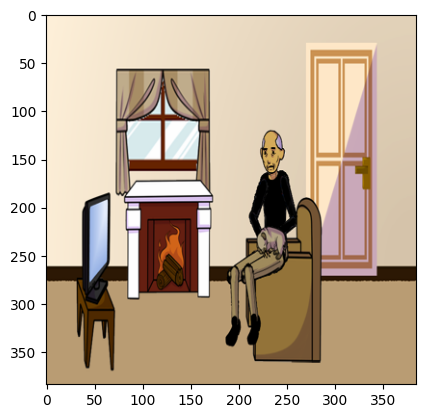

In [4]:
#Checking dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

idx = 1
image_mean = image_processor.image_mean
image_std = image_processor.image_std
unnormalized_image = (datasetLoaded[idx]["pixel_values"].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",text_processor.decode(datasetLoaded[idx]["input_ids"], skip_special_tokens=True))
print("Answer: ",text_processor.decode(datasetLoaded[idx]["labels"], skip_special_tokens=True))
print("Possible answers: ",text_processor.batch_decode(datasetLoaded[idx]["answer_choices"], skip_special_tokens=True))
plt.imshow(Image.fromarray(unnormalized_image))

In [5]:
#Split
train_size = int(len(datasetLoaded)*0.8)
val_size = int(len(datasetLoaded)*0.1)
test_size = int(len(datasetLoaded))-train_size-val_size
generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(datasetLoaded, [train_size, val_size, test_size], generator=generator)
print("Train size: ", train_size)
print("Test size: ", test_size)

Train size:  3200
Test size:  400


In [6]:
#Dataloader
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    multiple_choices = [item['answer_choices'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch, torch.stack(multiple_choices)

batch_size = 16
train_dataloader = DataLoader(train_dataset,
                              collate_fn=collate_fn,
                              batch_size=batch_size,
                              shuffle=False)
val_dataloader = DataLoader(val_dataset,
                            collate_fn=collate_fn,
                            batch_size=batch_size,
                            shuffle=False)

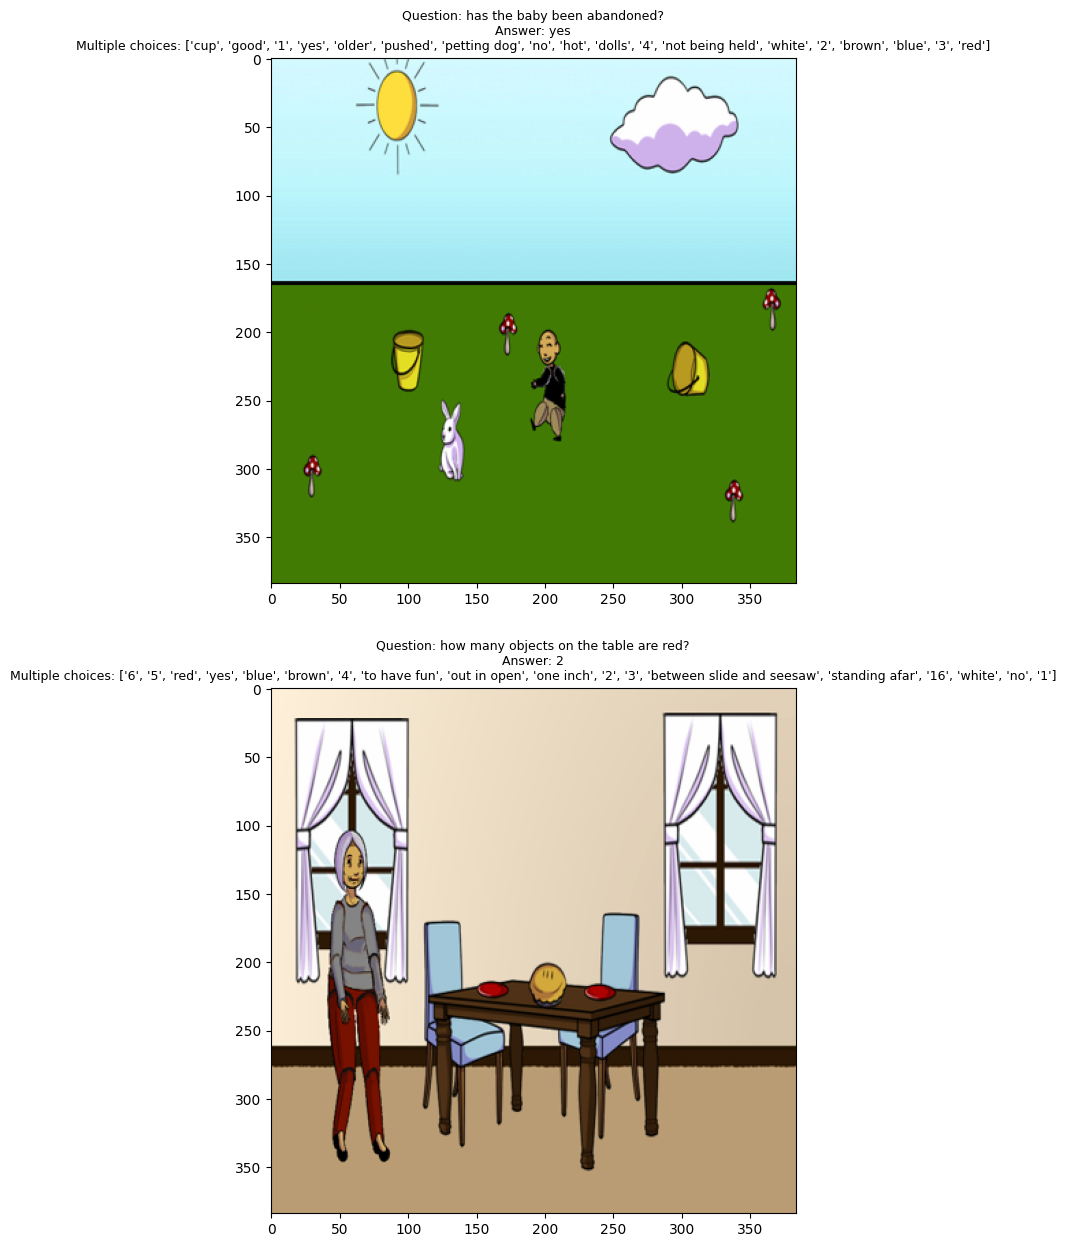

In [7]:
#Testing
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image

image_mean = image_processor.image_mean
image_std = image_processor.image_std

#Checking data
fig=plt.figure(0, (28, 15))

element, multiple_choices = next(iter(train_dataloader))

for i in range(batch_size):
    ax = fig.add_subplot(2,int(batch_size/2),i+1)
    
    img_tensor = element["pixel_values"][i].squeeze(0)
    unnormalized_image = (img_tensor.cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    
    question = text_processor.decode(element["input_ids"][i], skip_special_tokens=True)
    answer = text_processor.decode(element["labels"][i], skip_special_tokens=True)
    
    multiple_choices_text = text_processor.batch_decode(multiple_choices[i],skip_special_tokens=True)

    ax.imshow(Image.fromarray(unnormalized_image)) #Converting to matplotlib format
    ax.set_title("Question: "+question+"\nAnswer: "+str(answer)+
                 "\nMultiple choices: "+str(multiple_choices_text), fontsize=9)

**Train the model**

In [8]:
from torch.utils.tensorboard import SummaryWriter
import os 
from transformers import BlipForQuestionAnswering

#Tensorboard
currentModelIteration = "5e-5_3k"
folder_path = os.path.join("runs", "trainingsBLIP", currentModelIteration)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
# for param in model.parameters():
#     param.requires_grad = False

# for param in model.text_encoder.parameters():
#     param.requires_grad = True
#Freezing ViT layers
writer = SummaryWriter(folder_path)
print(model)

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [9]:
def train(dataloader, vqa_model, optimizer, clip_value, epoch):
    size = len(dataloader.dataset)
    vqa_model.train()
    train_correct_num, train_total, train_cost_acum = 0, 0, 0.0

    for batch_i, (batch, _multiple_answers) in enumerate(dataloader):    
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        optimizer.zero_grad()      
        outputs = vqa_model(**batch)
        #predicted_answers = text_processor.batch_decode(outputs[0], skip_special_tokens=True)
        #correct_answers = text_processor.batch_decode(batch["labels"][0], skip_special_tokens=True)

        #Backpropagation
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vqa_model.parameters(), max_norm=clip_value, error_if_nonfinite=True)
        optimizer.step()
        
        #Ploting results
        train_cost_acum += loss
        #train_correct_num += sum(pred_answer == correct_answer for pred_answer, correct_answer in zip(predicted_answers, correct_answers))
        #train_total += len(correct_answers)

        if batch_i % 10 == 1:
            writer.add_scalar('Loss/training', float(train_cost_acum)/batch_i, epoch * size + batch_i)
            #writer.add_scalar('Accuracy/training', float(train_correct_num)/train_total, epoch * size + batch_i)
            loss, current = loss.item(), batch_i*batch_size
            print("loss: ", loss, current, size)

In [10]:
def eval(dataloader, model, epoch):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch, _multiple_answers in dataloader:    
            batch = {k:v.to(device) for k,v in batch.items()}

            outputs = model.generate(**batch)
            predicted_answers = text_processor.batch_decode(outputs,skip_special_tokens=True)
            correct_answers = text_processor.batch_decode(batch['labels'], skip_special_tokens=True)
            correct += sum(pred_answer == correct_answer for pred_answer, correct_answer in zip(predicted_answers, correct_answers))   

            #Debugging
            # print("Question: ", text_processor.batch_decode(batch["input_ids"], skip_special_tokens=True)[0])      
            # print("Answer: ", text_processor.batch_decode(batch["labels"], skip_special_tokens=True)[0])  
            # print("Predicted: ", text_processor.batch_decode(outputs, skip_special_tokens=True)[0])
                        
    correct /= size

    #Ploting results
    writer.add_scalar('Accuracy/test', correct*100, epoch)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%")
    return 100*correct

In [11]:
#Hyperparameters and optim
import torch

clip_value = 1.0
learning_rate = 5e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
model.to(device)

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [12]:
#Early stopping parameters
n_epochs = 50
early_stop_threshhold = 5
best_accuracy = -1
best_epoch = -1

def checkpoint(model, filename):
    folder_path = os.path.join("runs", "best_model", currentModelIteration)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    torch.save(model.state_dict(), os.path.join(folder_path, filename))
    
def resume(model, filename):
    model.load_state_dict(torch.load(os.path.join("runs", "checkpoint_SolvingCropping", filename)))

In [14]:
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, optimizer, clip_value, epoch)
    acc = eval(val_dataloader, model, epoch)
    if acc>best_accuracy:
        best_accuracy = acc
        best_epoch = epoch
        checkpoint(model, "best_model.pth")
    elif (epoch-best_epoch) > early_stop_threshhold:
        print("--Early stopped training--")
        break

Epoch 1
-------------------------------


c:\Users\Zetans\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\generation\utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


KeyboardInterrupt: 